In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun2_ntuple/pn_kshortfilter_1M_events_r0005_b47445.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
hists = {}
hists["Target_mass_hist"] = hist.Hist("Target SP Kaons",
                                hist.Bin("m", r"Mass", 100, 0, 3500),
                            )       

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    target_kaon_dau1 = ldmx_events['TSP_Kaon_dau1']
    target_kaon_dau2 = ldmx_events['TSP_Kaon_dau2']
    target_kaon_dau3 = ldmx_events['TSP_Kaon_dau3']
    target_kaon_dau4 = ldmx_events['TSP_Kaon_dau4']
    
    kshort_pdgid = 310
    chargedpion_pdgid = 211
    
    # first select only events w 2 daughters
    mask_2dau = (target_kaon_dau1.gd==0)
    mask_4dau = (target_kaon_dau1.gd==1)
    
    kshort_mask = (abs(target_kaon_dau1.mompdgID)==kshort_pdgid)
        
    pidau1_mask = (abs(target_kaon_dau1.pdgID)==chargedpion_pdgid)
    pidau2_mask = (abs(target_kaon_dau2.pdgID)==chargedpion_pdgid)

    pidau1 = get_vector(target_kaon_dau1[pidau1_mask & kshort_mask & mask_2dau])
    pidau2 = get_vector(target_kaon_dau2[pidau2_mask & kshort_mask & mask_2dau])

    pisum = (pidau1 + pidau2)
    print(pisum.mass)
    print(flat(pidau1.mass).shape)
    print(flat(pisum.mass).shape)
    
    hists["Target_mass_hist"].fill(      
                                 m=flat(pisum),      
                                )
    
    return

In [6]:
nchunk = 0
for chunk in ldmx_dict:
    if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
(0,)
(0,)


<Hist (m) instance at 0x12e29e070>


/usr/local/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


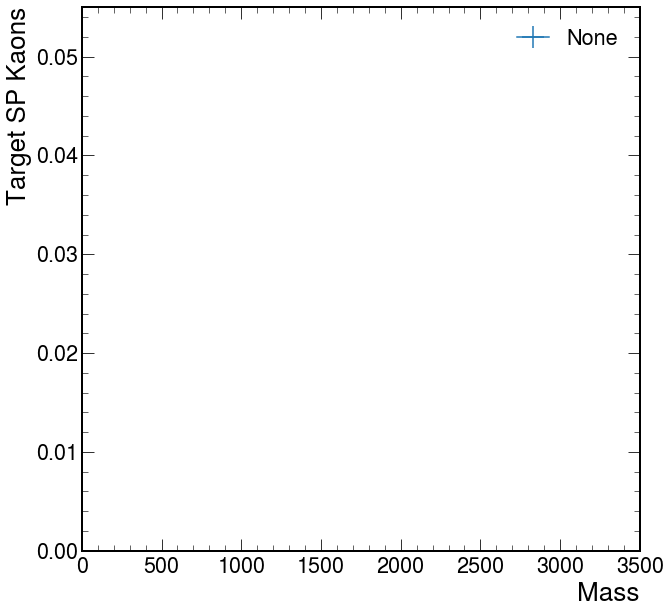

In [7]:
print(hists["Target_mass_hist"])
fig, ax = plt.subplots()
hist.plot1d(hists["Target_mass_hist"],ax=ax,clear=False);
#leg = ax.legend([r'$\pi ^+/-$ from $K_s$'])